In [1]:
import string;
import gensim
from gensim import corpora, models
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from stop_words import get_stop_words
from gensim.models import CoherenceModel
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')

import pyLDAvis
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint

import matplotlib.pyplot as plt
%matplotlib inline

# We import sklearn.
import sklearn

import time

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nolanmccafferty/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
docs = []
titles = []
locations = []
lines = ''
title = ''
location = ''

In [13]:
with open('sales_associate_1000_similar.txt', 'r') as rf:
    for line in rf:
        if location == '':
            location = line[:-1]
            locations.append(location)
        if title == '':
            title = line[:-1]
            titles.append(title)
            location = ''
        if line == 'zzz\n':
            docs.append(lines)
            lines = ''
            title = ''
            location = ''
        else:
            lines = lines+line 

In [14]:
# stop words
en_stop = get_stop_words('en')

In [15]:
# stemmer
p_stemmer = PorterStemmer()

In [16]:
documents = []

for i in docs:
    # tokenize text
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = [x.lower() for x in tokenizer.tokenize(i)]
    
    # remove stop words, numbers, and short words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop and len(i) > 3 and not i.isdigit()]
    
    # stem and lemmatize tokens
    stemmed_tokens = [p_stemmer.stem(WordNetLemmatizer().lemmatize(i, pos='v')) for i in stopped_tokens]
    
    # add tokens to list
    documents.append(stemmed_tokens)

In [17]:
# turn tokenize documents into a id - term dictionary
dictionary = corpora.Dictionary(documents)

len(dictionary)

9092

In [18]:
# filter out words that are too frequent or too infrequent
dictionary.filter_extremes(no_below=0.02, no_above=0.5, keep_n=100000)

len(dictionary)

9074

In [19]:
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(document) for document in documents]

In [20]:
# creating object for LDA model
Lda = gensim.models.ldamodel.LdaModel

def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = Lda(corpus, num_topics=num_topics, id2word=dictionary, passes=20)        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print(num_topics)

    return model_list, coherence_values

In [21]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=documents, start=4, limit=16, step=2)

4
6
8
10
12
14


In [22]:
# Can take a long time to run, second half
model_list_2, coherence_values_2 = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=documents, start=16, limit=30, step=2)

16
18
20
22
24
26
28


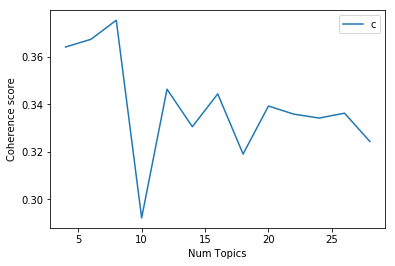

In [23]:
# Show graph
limit=30; start=4; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values + coherence_values_2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [24]:
# Print the coherence scores
for m, cv in zip(x, coherence_values + coherence_values_2):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 4  has Coherence Value of 0.3641
Num Topics = 6  has Coherence Value of 0.3674
Num Topics = 8  has Coherence Value of 0.3754
Num Topics = 10  has Coherence Value of 0.2922
Num Topics = 12  has Coherence Value of 0.3464
Num Topics = 14  has Coherence Value of 0.3306
Num Topics = 16  has Coherence Value of 0.3444
Num Topics = 18  has Coherence Value of 0.3191
Num Topics = 20  has Coherence Value of 0.3393
Num Topics = 22  has Coherence Value of 0.3359
Num Topics = 24  has Coherence Value of 0.3342
Num Topics = 26  has Coherence Value of 0.3363
Num Topics = 28  has Coherence Value of 0.3244


In [27]:
# choose the model with the highest Conherence value 
# num_topics = 8
optimal_model = model_list[2]

# Visualize the topics
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(optimal_model, corpus, dictionary, mds="tsne")

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
4     -58.858360  -3.732361       1        1  52.644939
3     -53.412933  13.440386       2        1  21.376534
5     -70.238739   6.992303       3        1   9.749670
7     -55.963440  31.260675       4        1   7.696871
0     -41.057343  26.556814       5        1   4.765304
1     -68.963226  22.574030       6        1   1.388734
2     -43.362659  -1.527188       7        1   1.249110
6     -35.496105  11.954226       8        1   1.128838, topic_info=     Category         Freq              Term        Total  loglift  logprob
term                                                                       
588   Default  1892.000000             insur  1892.000000  30.0000  30.0000
79    Default  1296.000000             agent  1296.000000  29.0000  29.0000
112   Default  1292.000000            market  1292.000000  28.0000  28.0000
244   Default  1463.000000             state  1463.000000  27.0000  27.0000
142   Default  1367.000000           success  1367.000000  26.0000  26.0000
4452  Default  1095.000000              farm  1095.000000  25.0000  25.0000
110   Default   941.000000            licens   941.000000  24.0000  24.0000
311   Default  1429.000000            provid  1429.000000  23.0000  23.0000
10    Default  1650.000000              busi  1650.000000  22.0000  22.0000
39    Default   897.000000             great   897.000000  21.0000  21.0000
49    Default  1124.000000              lead  1124.000000  20.0000  20.0000
373   Default   815.000000            client   815.000000  19.0000  19.0000
196   Default  1106.000000            career  1106.000000  18.0000  18.0000
265   Default  1234.000000           employe  1234.000000  17.0000  17.0000
590   Default   794.000000              life   794.000000  16.0000  16.0000
139   Default   707.000000              sell   707.000000  15.0000  15.0000
1107  Default   491.000000          independ   491.000000  14.0000  14.0000
289   Default   522.000000              best   522.000000  13.0000  13.0000
251   Default   574.000000              want   574.000000  12.0000  12.0000
102   Default   620.000000              hire   620.000000  11.0000  11.0000
232   Default   674.000000           program   674.000000  10.0000  10.0000
287   Default   959.000000              abil   959.000000   9.0000   9.0000
739   Default   436.000000              take   436.000000   8.0000   8.0000
304   Default  1122.000000             motiv  1122.000000   7.0000   7.0000
125   Default   725.000000            prefer   725.000000   6.0000   6.0000
626   Default   740.000000            member   740.000000   5.0000   5.0000
99    Default   850.000000              goal   850.000000   4.0000   4.0000
306   Default   352.000000             organ   352.000000   3.0000   3.0000
330   Default  1066.000000            commun  1066.000000   2.0000   2.0000
57    Default  1241.000000              need  1241.000000   1.0000   1.0000
...       ...          ...               ...          ...      ...      ...
259    Topic8    46.832413              book   132.479340   3.4441  -4.0884
496    Topic8    45.976067             allow   157.567673   3.2522  -4.1068
245    Topic8    46.712574          structur   182.826447   3.1195  -4.0909
357    Topic8    46.365536        telemarket   198.293701   3.0308  -4.0984
144    Topic8    46.052254            system   229.179596   2.8793  -4.1052
1107   Topic8    92.593178          independ   491.165070   2.8154  -3.4067
34     Topic8    46.086460            expand   246.001617   2.8092  -4.1044
563    Topic8    46.270981             group   250.488342   2.7951  -4.1004
455    Topic8    46.015816             dedic   252.105011   2.7831  -4.1060
588    Topic8   285.338165             insur  1892.463623   2.5920  -2.2813
90     Topic8    45.853561           contact   332.587402   2.5025  -4.1095
291    Topic8    46.466507  commissionsalari   354.01

In [28]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=documents):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=documents)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.9907,"skill, call, must, manag, benefit, provid, off...","[sale, closer, denver, base, commissionssal, r..."
1,1,4.0,0.8281,"skill, call, must, manag, benefit, provid, off...","[custom, servic, repres, sandi, summarytop, re..."
2,2,4.0,0.7215,"skill, call, must, manag, benefit, provid, off...","[phone, sale, expert, houston, phone, sale, ex..."
3,3,4.0,0.5929,"skill, call, must, manag, benefit, provid, off...","[entri, level, sale, repres, houston, houston,..."
4,4,4.0,0.8210,"skill, call, must, manag, benefit, provid, off...","[concierg, breckenridg, uniqu, opportun, outgo..."
5,5,4.0,0.7802,"skill, call, must, manag, benefit, provid, off...","[junior, consult, costa, mesa, need, self, mot..."
6,6,4.0,0.9234,"skill, call, must, manag, benefit, provid, off...","[canvass, manag, denver, look, career, market,..."
7,7,3.0,0.7912,"busi, call, manag, base, person, product, offe...","[insid, sale, repres, date, specialist, york, ..."
8,8,3.0,0.7824,"busi, call, manag, base, person, product, offe...","[insid, sale, repres, date, specialist, diego,..."
9,9,4.0,0.7245,"skill, call, must, manag, benefit, provid, off...","[entri, level, medic, sale, orlean, want, care..."


In [29]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5563,"insur, abil, orient, licens, life, commun, off...","[offic, repres, state, farm, agent, team, memb..."
1,1.0,0.9416,"wine, incom, manag, life, contract, present, m...","[pizza, maker, miami, beach, pizza, maker, wan..."
2,2.0,0.8713,"welk, resort, life, help, need, career, chang,...","[entri, level, sale, repres, mount, lebanon, r..."
3,3.0,0.9970,"busi, call, manag, base, person, product, offe...","[entri, level, outsid, suppli, sale, base, hig..."
4,4.0,0.9977,"skill, call, must, manag, benefit, provid, off...","[hear, instrument, specialist, nashvil, summar..."


In [30]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head()

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,4.0,"skill, call, must, manag, benefit, provid, off...",20.0,0.0100
1,4.0,"skill, call, must, manag, benefit, provid, off...",14.0,0.0070
2,4.0,"skill, call, must, manag, benefit, provid, off...",10.0,0.0050
3,4.0,"skill, call, must, manag, benefit, provid, off...",456.0,0.2278
4,4.0,"skill, call, must, manag, benefit, provid, off...",1190.0,0.5944


In [31]:
topics = {}
vectors = []
for i,idx in enumerate(documents):
        # get the topic percentages for each document
        bow = dictionary.doc2bow(idx)
        v = optimal_model.get_document_topics(bow)
        
        # key => value, document number => topic vector
        topics[i] = v
        
        # iterate through the topic vector
        dict = {}
        for j,jdx in enumerate(v):
            # key => value, topic number => percentage of document
            dict[jdx[0]] = jdx[1]

        # give the dictionary 20 keys, one for each topic
        vector = []
        for k in range(6):
            # if the topic was in the original vector, use the given percentage
            if k in dict.keys():
                vector.append(dict[k])
            # else give the topic the percentage zero
            else:
                vector.append(0)
        # add the vector to the set of document vectors
        vectors.append(np.asarray([vector]))

In [32]:
def top_5_similar(vectors):
    for j in range(5):
        index = np.random.randint(0,len(vectors)-1)
        cosines = {}
        euclideans = {}
        for i,ind in enumerate(vectors):
            if i != index:
                cosines[sklearn.metrics.pairwise.cosine_similarity(vectors[index],vectors[i])[0][0]] = i
                euclideans[sklearn.metrics.pairwise.euclidean_distances(vectors[index],vectors[i])[0][0]] = i

        top_5_cosine = sorted(cosines.keys(), reverse=True)[:6]
        top_5_euclidean = sorted(euclideans.keys())[:6]
        print("\nTop 5 cosine similarity to:", titles[index])
        for i,indx in enumerate(top_5_cosine):
            print("  ", round(top_5_cosine[i], 3), titles[cosines[top_5_cosine[i]]])
            
        print("Lowest 5 euclidean distance from:", titles[index])
        for k,inx in enumerate(top_5_euclidean):
            print("  ", round(top_5_euclidean[k], 3), titles[euclideans[top_5_euclidean[k]]])

In [33]:
top_5_similar(vectors)


Top 5 cosine similarity to: BDC Associate
   1.0 Wellness Manager
   1.0 Virtual Life and Health Agent
   1.0 Hiring precious metals appointment setters today!
   1.0 Wine Sales Representative
   1.0 Wine Sales Representative
   0.999 Part Time to Full Time Sales Associate
Lowest 5 euclidean distance from: BDC Associate
   0.0 BDC Associate
   0.0 Dealership Account Manager
   0.0 Dealership Account Manager
   0.003 Sales Product Specialist $2,500 SIGNING BONUS AVAILABLE
   0.003 Sales Product Specialist $2,500 SIGNING BONUS AVAILABLE
   0.004 Recruiter (Contract)

Top 5 cosine similarity to: Wellness Manager
   1.0 Full Time Fitness Career
   1.0 Virtual Life and Health Agent
   1.0 Hiring precious metals appointment setters today!
   1.0 Wine Sales Representative
   1.0 Wine Sales Representative
   0.999 Part Time to Full Time Sales Associate
Lowest 5 euclidean distance from: Wellness Manager
   0.0 Wellness Manager
   0.0 Entry Level Sales Position
   0.0 Entry Level Sales Position

In [73]:
def top_1000_similar(vectors):
        indices = []
        index = 32535
        cosines = {}
        for i,ind in enumerate(vectors):
            if i != index:
                cosines[sklearn.metrics.pairwise.cosine_similarity(vectors[index],vectors[i])[0][0]] = i

        top_1000_cosine = sorted(cosines.keys(), reverse=True)[:1001]
        print("\nTop 10 cosine similarity to:", titles[index])
        for i,ind in enumerate(top_1000_cosine):
            print("  ", round(ind, 3), titles[cosines[ind]])
            indices.append(cosines[ind])
            
        return indices

indices = top_1000_similar(vectors)


Top 10 cosine similarity to: Sales Associate
   0.997 Sales Closers B2B
   0.996 Customer Service Representative
   0.996 Phone Sales Expert
   0.994 Entry Level sale Representative
   0.993 Concierge
   0.993 Junior Consultant
   0.993 Canvassing Manager
   0.993 Inside Sales Representative - Dating Specialist
   0.992 Inside Sales Representative - Dating Specialist
   0.992 Entry Level Medical Sales
   0.991 Call Center Customer Service Rep
   0.989 Inside Sales Representative - Dating Specialist
   0.988 Associate Orthodontist
   0.987 Inside Sales Representative - Dating Specialist
   0.987 Entry Level Marketing
   0.986 Call Center Representative
   0.986 Sales Representative
   0.985 Customer Service Representative/Call Center
   0.985 Wax Specialist
   0.985 Sales Associate/Customer Service
   0.985 Cell Phone Sales
   0.984 Inside Sales Representative
   0.984 Hiring precious metals appointment setters today!
   0.984 Business to Business Appointment Setters
   0.984 Verizon W

   0.916 Sales Rep
   0.916 Office Assistant
   0.916 Inside Sales Associate
   0.916 BDC Associate
   0.916 Wine Sales Representative
   0.916 Residential Field Sales Representative - Outside Sales
   0.916 Secretary
   0.916 Stellar Optician
   0.915 Sales Associate/Product Specialist
   0.915 Sales-no cold calls-EB-Part/Full time 70%-80% buyers
   0.915 Outside Sales Representative
   0.915 Call Center Medical Telesales Representative
   0.915 Personal Administrative Assistant/ Marketing Coordinator
   0.915 Entry Level Associate
   0.915 Front Desk Receptionist for Upscale Men's Salon
   0.915 Sales Reps Needed!
   0.915 Call Center Customer Service Representative
   0.914 Dealership Account Manager
   0.914 Inside Sales Associate
   0.914 Entry Level Sales Representative
   0.914 Brand Ambassador
   0.914 Sales Consultant
   0.914 Outside Sales Representative - B2B Medical
   0.914 Licensed Br 3 Termite Inspector ($4,500 Sign on Bonus)
   0.914 Fitness Directors & Assistant Direct

   0.888 Customer Service Representative
   0.888 Home based Call Center Representative
   0.888 Receptionist - State Farm Agent Team Member
   0.888 Solar Energy Consultant- All Levels
   0.888 Personal Assistant
   0.888 Receptionist - State Farm Agent Team Member
   0.888 Benefits Coordinator
   0.888 Receptionist - State Farm Agent Team Member
   0.888 Receptionist - State Farm Agent Team Member
   0.888 Receptionist - State Farm Agent Team Member
   0.888 Assistant Personal Training Director
   0.888 Account Representative
   0.888 Receptionist - State Farm Agent Team Member
   0.888 Water sample collector/ Surveyor
   0.888 Business Development Coordinator
   0.887 Entry Level Account Manager
   0.887 Customer Relations Specialist
   0.887 Vacation Sales Consultant
   0.887 Inside Sales Representative/ Account Manager
   0.887 In- home Sales Opportunity
   0.887 Sales Consultant
   0.887 Receptionist - State Farm Agent Team Member
   0.887 Sale Associate
   0.887 Call Center Repr

In [74]:
"""write out top 1000 similar jobs to new file"""
filename = titles[32535].replace(" ", "_") + '_1000_similar.txt'
with open(filename, 'w') as wf:
    for i in indices:
        wf.write(docs[i])
        wf.write('zzz\n')

In [75]:
filename = titles[32535].replace(" ", "_") + '_1000_similar.txt'
filename

'Sales_Associate_1000_similar.txt'